In [1]:
import numpy as np
import matplotlib. pyplot as plt
from sklearn.model_selection import train_test_split

### Data Generate :

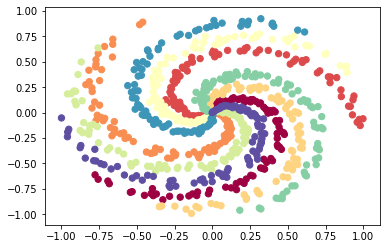

(765, 2)
(765, 9)


In [2]:
N = 85 # number of points per class
D = 2 # dimensionality
K = 9 # number of classes
inputs = np.zeros((N*K,D)) # data matrix (each row = single example)
targets = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.1 # theta
    inputs[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    targets[ix] = j

# # lets visualize the data:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets, s=40, cmap=plt.cm.Spectral)
plt.show()

one_hot = np.zeros([N*K ,K], dtype=np.int)
for i in range(len(targets)):
    one_hot[i][targets[i]] = 1 
targets = one_hot

print (inputs.shape)
print (targets.shape)

### Preparation Class :

In [3]:
class KFold:
    def __init__(self, dataset, test_split, k):
        self.k = k
        self.dataset = dataset
        self.dsIndx = np.arange(dataset[0].shape[0])
        np.random.shuffle(self.dsIndx)
        self.num_samples = len(self.dsIndx)
        
        self.num_test = int(self.num_samples * test_split)
        self.num_train_valid= self.num_samples - self.num_test
        self.batch_size = int(self.num_train_valid / k)
        self.train_indx = self.dsIndx[0:self.num_train_valid]
        self.num_train = self.train_indx.shape[0]
        self.folds = {}
        index = 0
        for f in range(k):
            self.folds[str(f)] = self.train_indx[index:index+self.batch_size]
            index += self.batch_size
        
        if test_split == 0:
            self.test_indx = self.dsIndx
            self.num_test = self.num_samples
        else:
            self.test_indx = self.dsIndx[self.num_train_valid::]
        self.test_data = self.dataset[0][self.test_indx], self.dataset[1][self.test_indx]
        
        self.valid_index = 0
        
    def train_valid_batchs(self):
        for i in range(self.k):
            train_folds ={}
            for i in range(self.k):
                if self.valid_index == i:
                    continue
                train_folds[str(i)] = self.folds[str(i)]
            train_data_indx = [value for values in train_folds.values() for value in values]
            valid_data_indx = self.folds[str(self.valid_index)] 
            self.train_data = self.dataset[0][train_data_indx], self.dataset[1][train_data_indx]
            self.valid_data = self.dataset[0][valid_data_indx], self.dataset[1][valid_data_indx]
            self.valid_index +=1
            yield self.train_data , self.valid_data
        self.valid_index = 0
             
    def info(self):
        print('Number of Samples: {}\n| # Train (with Validation): {} |# Test: {} | # Folds: {} | # Items in each Folds: {}'.format
              (self.num_samples, self.num_train, self.num_test, self.k, self.batch_size))                    

### Model Class :

In [4]:
class NN:
    def __init__(self, layers):
        w1 = np.random.randn(layers[0], layers[1]) / np.sqrt(layers[0])
        w2 = np.random.randn(layers[1], layers[2]) / np.sqrt(layers[1])
        w3 = np.random.randn(layers[2], layers[3]) / np.sqrt(layers[2])
        b1 = np.zeros((1, layers[1]))
        b2 = np.zeros((1, layers[2]))
        b3 = np.zeros((1, layers[3]))
        self.weights= {}
        self.set_weights(w1,b1,w2,b2,w3,b3)
    
    def get_weights(self):
        w1=self.weights['w1']
        b1=self.weights['b1']
        w2=self.weights['w2']
        b2=self.weights['b2']
        w3=self.weights['w3']
        b3=self.weights['b3']
        return w1, b1, w2, b2, w3, b3
    
    def set_weights(self, w1,b1,w2,b2,w3,b3):
        self.weights['w1'] = w1
        self.weights['b1'] = b1
        self.weights['w2'] = w2
        self.weights['b2'] = b2
        self.weights['w3'] = w3
        self.weights['b3'] = b3

    
    def forward(self, x):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        hidden1 = np.maximum(0, np.dot(x, w1) + b1)
        hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
        linear = np.dot(hidden2, w3) + b3
        normalize_exp = np.exp(linear - np.max(linear))
        y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)
        return y_hat 
    
    def test(self, Data):
        x, y = Data.test_data
        y_hat = self.forward(x)
        loss = -np.sum(y * np.log(y_hat)) / Data.num_test
        accuracy = (np.argmax(y , axis=1) == np.argmax(y_hat, axis=1)).mean()
        print('Test Loss: {:.4f}, Accuracy: {:.1f}%'.format(loss, accuracy*100))
        
    def backward(self, Data, epochs, lr, reg_rate=0., verbose=1, trend_plot=False):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        train_loss = []
        train_accuracy = []
        valid_loss = []
        valid_accuracy = []
        for epoch in range(epochs):   
            for (x, y), (x_val, y_val) in Data.train_valid_batchs():
                batch_size = x.shape[0]
                
                hidden1 = np.maximum(0, np.dot(x, w1) + b1)
                hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
                linear = np.dot(hidden2, w3) + b3
                normalize_exp = np.exp(linear - np.max(linear))
                y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)

                reg_loss = .5*reg_rate * np.sum(w1*w1) + .5*reg_rate * np.sum(w2*w2) + .5*reg_rate * np.sum(w3*w3)
                loss = (-np.sum(y * np.log(y_hat)) + reg_loss) / batch_size 

                d_loss = y_hat - y

                d_w3 = np.dot(hidden2.T, d_loss)
                d_b3 = np.sum(d_loss, axis=0, keepdims=True)

                d_hidden2 = np.dot(d_loss, w3.T)
                d_hidden2[hidden2 <=0 ] = 0

                d_w2 = np.dot(hidden1.T, d_hidden2)
                d_b2 = np.sum(d_hidden2, axis=0, keepdims=True)

                d_hidden1 = np.dot(d_hidden2, w2.T)
                d_hidden1[hidden1 <=0 ] = 0

                d_w1 = np.dot(x.T, d_hidden1)
                d_b1 = np.sum(d_hidden1, axis=0, keepdims=True)

                w1 += -lr * (d_w1 + reg_rate * w1)
                b1 += -lr * d_b1
                w2 += -lr * (d_w2 + reg_rate * w2)
                b2 += -lr * d_b2
                w3 += -lr * (d_w3 + reg_rate * w3)
                b3 += -lr * d_b3

                correct = (np.argmax(y , axis=1) == np.argmax(y_hat, axis=1)).mean()

                train_loss.append(loss)
                train_accuracy.append(correct)
            
                # validation phase
                num_valid = x_val.shape[0]
                y_hat = self.forward(x_val)
                loss = -np.sum(y_val * np.log(y_hat)) / num_valid
                accuracy = (np.argmax(y_val, axis=1) == np.argmax(y_hat, axis=1)).mean()

                valid_loss.append(loss)
                valid_accuracy.append(accuracy)

            if epoch % verbose == 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Accurecy: {:.1f}%, Validation Loss: {:.4f}, Validation Accuracy :{:.1f}%'.format
                     (epoch, epochs, train_loss[-1], 100*train_accuracy[-1], valid_loss[-1], 100*valid_accuracy[-1]))
        
        self.set_weights(w1,b1,w2,b2,w3,b3)
        print('Training Done.')
        
        if trend_plot:
            plt.figure(figsize=(5,5))
            plt.plot(train_loss, label = 'Trainig Loss')
            plt.plot(valid_loss, label = 'Validation Loss')
            plt.legend()
            plt.show()

            plt.figure(figsize=(5,5))
            plt.plot(train_accuracy, label = 'Trainig Accuracy')
            plt.plot(valid_accuracy, label = 'Validation Accuracy')
            plt.legend()
            plt.show()

Number of Samples: 765
| # Train (with Validation): 765 |# Test: 765 | # Folds: 10 | # Items in each Folds: 76
Epoch [0/2000], Loss: 2.0351, Accurecy: 17.0%, Validation Loss: 2.0002, Validation Accuracy :19.7%
Epoch [100/2000], Loss: 0.5643, Accurecy: 77.5%, Validation Loss: 0.5324, Validation Accuracy :80.3%
Epoch [200/2000], Loss: 0.2473, Accurecy: 92.5%, Validation Loss: 0.2978, Validation Accuracy :90.8%
Epoch [300/2000], Loss: 0.1815, Accurecy: 93.7%, Validation Loss: 0.1983, Validation Accuracy :93.4%
Epoch [400/2000], Loss: 0.1331, Accurecy: 96.9%, Validation Loss: 0.1535, Validation Accuracy :97.4%
Epoch [500/2000], Loss: 0.1682, Accurecy: 95.3%, Validation Loss: 0.1456, Validation Accuracy :96.1%
Epoch [600/2000], Loss: 0.1209, Accurecy: 95.9%, Validation Loss: 0.1477, Validation Accuracy :96.1%
Epoch [700/2000], Loss: 0.1651, Accurecy: 95.6%, Validation Loss: 0.2279, Validation Accuracy :92.1%
Epoch [800/2000], Loss: 0.1066, Accurecy: 96.8%, Validation Loss: 0.0773, Validatio

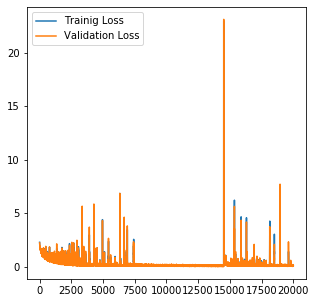

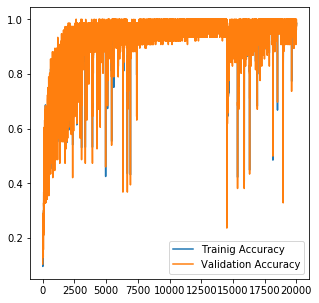

Test Loss: 0.0569, Accuracy: 98.7%


In [5]:
np.random.seed(1)
prepared_data = KFold((inputs, targets), test_split=0, k=10)
prepared_data.info()

nn = NN([2, 20, 30, 9])
nn.backward(prepared_data, epochs=2000, lr= .001, reg_rate=0.01, verbose=100, trend_plot= True)
nn.test(prepared_data)